In [10]:
def Parzen(N):
    import numpy as np
    W=np.zeros(N)
    for nr in range(N):
        W[nr]=1-(2*(nr-N/2)/N)**8
    return W

In [33]:
def newplotspace(filename1,filename2,datastart=26,types=True,minsec=False):
    # import basic packages and earth magnetic model
    import scipy.signal.windows as spsw
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import re
    import chaosmagpy as cp
    from chaosmagpy.model_utils import synth_values
    from chaosmagpy.data_utils import mjd2000
    from chaosmagpy.plot_utils import plot_timeseries
    model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')
    possible_characters = ('-', ' ')
    path='/usr/people/out/Documents/Magnetic_field/'
    
##### calculate values from observation station #####
    # read-in file of station
    File=open(f'{path}{filename2}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X2=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    
    if types: #if given in XYZ, types==true
        X2=HorX
        Y2=DeclY
        Z2=VertZ
            
    else: #if given in HDZ, types==false
        for item in range(len(DeclY)):
            X2.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y2=DeclY
        Z2=VertZ
        
    File=open(f'{path}{filename1}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X1=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    try:
        os.mkdir(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
    except Exception:
        pass
    
    if types: #if given in XYZ, types==true
        X1=HorX
        Y1=DeclY
        Z1=VertZ
            
    else: #if given in HDZ, types==false
        for item in range(len(DeclY)):
            X1.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y1=DeclY
        Z1=VertZ
##### calculate model value of magnetic field #####
    # set up
    if minsec:
        secormin='sec'
    else:
        secormin='min'

    if int(dates[2])==31:
        if int(dates[1])==12:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0])+1,1,1), num=N)
        else:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0]),int(dates[1])+1,1), num=N)
    else:
        time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])),
                           mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)
    
##### subtract the two data sets! #####
    SpaceX=np.subtract(X1,X2)
    SpaceY=np.subtract(Y1,Y2)
    SpaceZ=np.subtract(Z1,Z2)
        
##### plot data #####
    figx=plt.figure(figsize=(20,10))
    ax1=figx.add_subplot(311)
    ax11=figx.add_subplot(312)
    ax12=figx.add_subplot(313)
    ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax12.set_xlabel('time (days after 1 jan 2000)')
    ax11.set_ylabel('$B_\\theta$ (nt)')
    ax11.plot(time,X1,label='observed',color='blue')
    ax12.plot(time,X2,label='model',color='green')
    ax1.plot(time,SpaceX,label='residue',color='red')
    ax1.legend()
    ax11.legend()
    ax12.legend()

    figy=plt.figure(figsize=(20,10))
    ax2=figy.add_subplot(311)
    ax21=figy.add_subplot(312)
    ax22=figy.add_subplot(313)
    ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax22.set_xlabel('time (days after 1 jan 2000)')
    ax21.set_ylabel('$B_\\phi$ (nt)')
    ax21.plot(time,Y1,label='total',color='blue')
    ax22.plot(time,Y2,label='model',color='green')
    ax2.plot(time,SpaceY,label='residue',color='red')
    ax2.legend()
    ax21.legend()
    ax22.legend()

    figz=plt.figure(figsize=(20,10))
    ax3=figz.add_subplot(311)
    ax31=figz.add_subplot(312)
    ax32=figz.add_subplot(313)
    ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax32.set_xlabel('time (days after 1 jan 2000)')
    ax31.set_ylabel('$B_r$ (nt)')
    ax31.plot(time,Z1,label='total',color='blue')
    ax32.plot(time,Z2,label='model',color='green')
    ax3.plot(time,SpaceZ,label='residue',color='red')
    ax3.legend()
    ax31.legend()
    ax32.legend()
    plt.show()
    
    figall=plt.figure(figsize=(20,10))
    ax4=figall.add_subplot(311)
    ax41=figall.add_subplot(312)
    ax42=figall.add_subplot(313)
    ax4.set_title('Radial component')
    ax41.set_title('Longitudinal component')
    ax41.set_ylabel('nanoteslas')
    ax42.set_title('Latitudional component')
    ax4.plot(time,SpaceZ,color='red')
    ax41.plot(time,SpaceY,color='red')
    ax42.plot(time,SpaceX,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')
    
##### calculate frequency spectrum #####
    # try to get time derivative and frequency at which this happens, only horizontal components matter
    dXdt=np.zeros(len(SpaceX)) # define length array
    dYdt=np.zeros(len(SpaceY))

    for item in range(len(SpaceX)-1): # obtain derivative
        dXdt[item]=SpaceX[item+1]-SpaceX[item]
        dYdt[item]=SpaceY[item+1]-SpaceY[item]

    figx=plt.figure()
    ax1=figx.add_subplot()
    ax1.set_title('d$B_X$/dt at ' + station)
    ax1.set_xlabel('time (days after 1 jan 2000)')
    ax1.set_ylabel(f'd$B_X$/dt (nt/{secormin})')
    ax1.plot(time,dXdt,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

    figy=plt.figure()
    ax2=figy.add_subplot()
    ax2.set_title('d$B_Y$/dt at ' + station)
    ax2.set_xlabel('time (days after 1 jan 2000)')
    ax2.set_ylabel(f'd$B_Y$/dt (nt/{secormin})')
    ax2.plot(time,dYdt,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')
    
    # get frequencyplot
    SpaceX1=np.zeros(3*len(SpaceX))
    SpaceY1=np.zeros(3*len(SpaceY))
    SpaceX1[:len(SpaceX)]=SpaceX1[0]; SpaceX1[2*len(SpaceX):]=SpaceX1[-1]; SpaceX1[len(SpaceX):2*len(SpaceX)]=SpaceX
    SpaceY1[:len(SpaceY)]=SpaceY1[0]; SpaceY1[2*len(SpaceY):]=SpaceY1[-1]; SpaceY1[len(SpaceY):2*len(SpaceY)]=SpaceY
    
    dXdt2=SpaceX1*Parzen(3*N)
    dYdt2=SpaceY1*Parzen(3*N)
    FdX=np.fft.rfft(dXdt2) # get frequency component
#     FdX=np.abs(np.fft.rfftshift(FdXshift)) # shift it to the middle of the plot
    FdY=np.fft.rfft(dYdt2) # get frequency component
#     FdY=np.abs(np.fft.fftshift(FdYshift)) # shift it to the middle of the plot
    
    if minsec:
        Nu_c=1./(2.*1) # Nyquist frequency Hz
        df=1./N/3 #frequencystepping
    else:
        Nu_c=1./(2*60.)
        df=1./(N*60)/3
    freq=np.arange(0,Nu_c+df,df)
    # freq=np.fft.fftfreq(len(dXdt),60)
    figfx=plt.figure()
    ax1=figfx.add_subplot()
    ax1.set_title('frequencyplot at ' + station)
    ax1.set_xlabel('frequency X (Hz)')
    ax1.set_xlim(0,0.001)
    ax1.set_ylabel('Amplitude')
    ax1.plot(freq,abs(FdX),label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
    figfy=plt.figure()
    ax2=figfy.add_subplot()
    ax2.set_title('frequencyplot at ' + station)
    ax2.set_xlabel('frequency Y (Hz)')
    ax2.set_xlim(0,0.001)
    ax2.set_ylabel('Amplitude')
    ax2.plot(freq,abs(FdY),label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyY.png')
    
    ### horizontal component ###
    Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
    dHdt=np.zeros(len(Hor_comp))
    for item in range(len(Hor_comp)-1): # obtain derivative
        dHdt[item]=Hor_comp[item+1]-Hor_comp[item]
    dHdt2=np.sqrt(SpaceX1**2+SpaceY1**2)*Parzen(3*N)
#     FdHshift=np.fft.fft(dHdt2)
    FdH=np.abs(np.fft.rfft(dHdt2))
    figH=plt.figure()
    ax1=figH.add_subplot(211)
    ax1.set_title('horizontal component at ' + station)
    ax1.set_xlabel('time')
    ax1.set_ylabel('nT')
    ax1.plot(time,Hor_comp,color='red')
    ax2=figH.add_subplot(212)
    ax2.set_xlabel('time')
    ax2.set_ylabel('sec')
    ax2.plot(time,dHdt,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')
    
    figHf=plt.figure()
    ax3=figHf.add_subplot(111)
    ax3.set_xlabel('frequency (Hz)')
    ax3.set_ylabel('horizontal Amplitude')
    ax3.plot(freq,abs(FdH),color='red')
    ax3.set_xlim(0,0.001)
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_frequency.png')
    
# ##### save files #####
    newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
    for i in range(N):
        newfile.loc[i]=SpaceX[i], SpaceY[i], SpaceZ[i], Hor_comp[i], dXdt[i], dYdt[i], dHdt[i]
    newfile.to_csv(path_or_buf=f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)

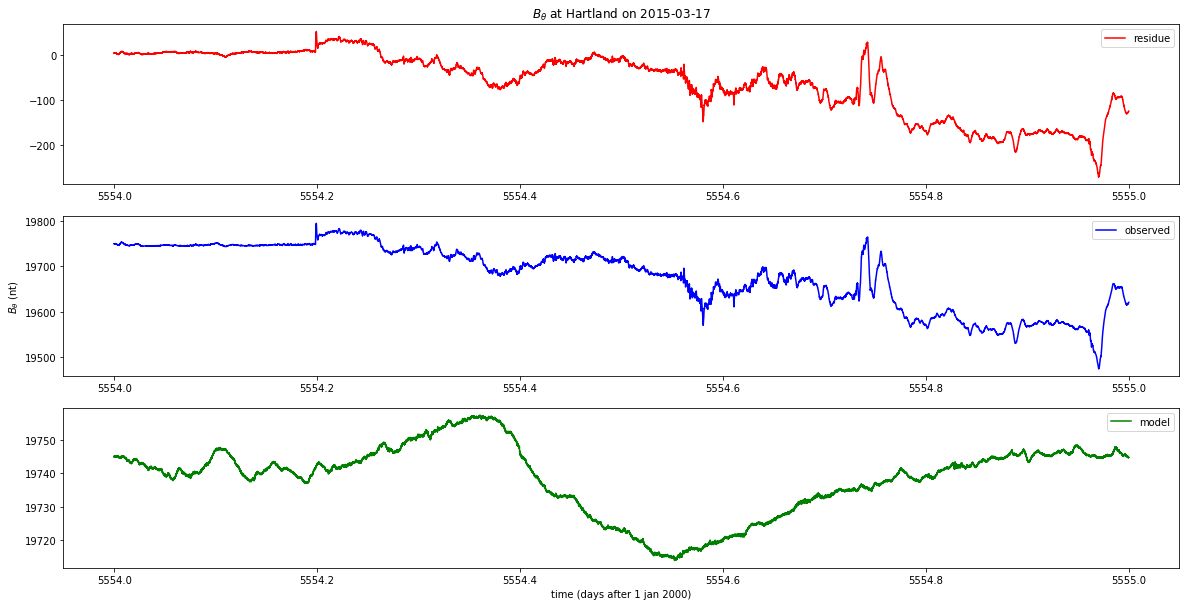

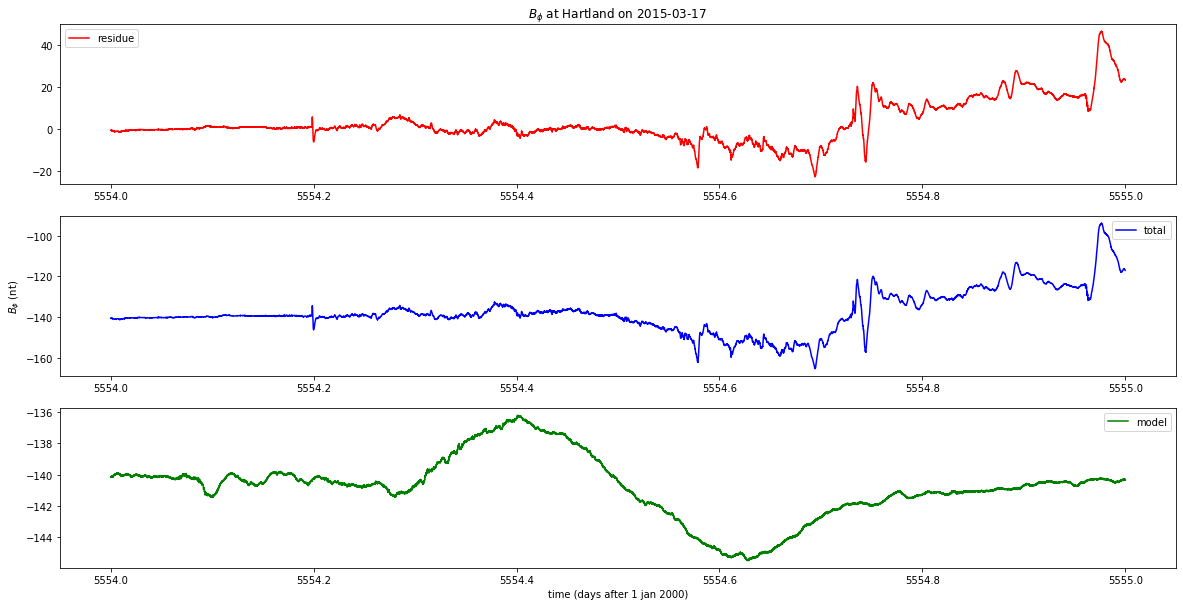

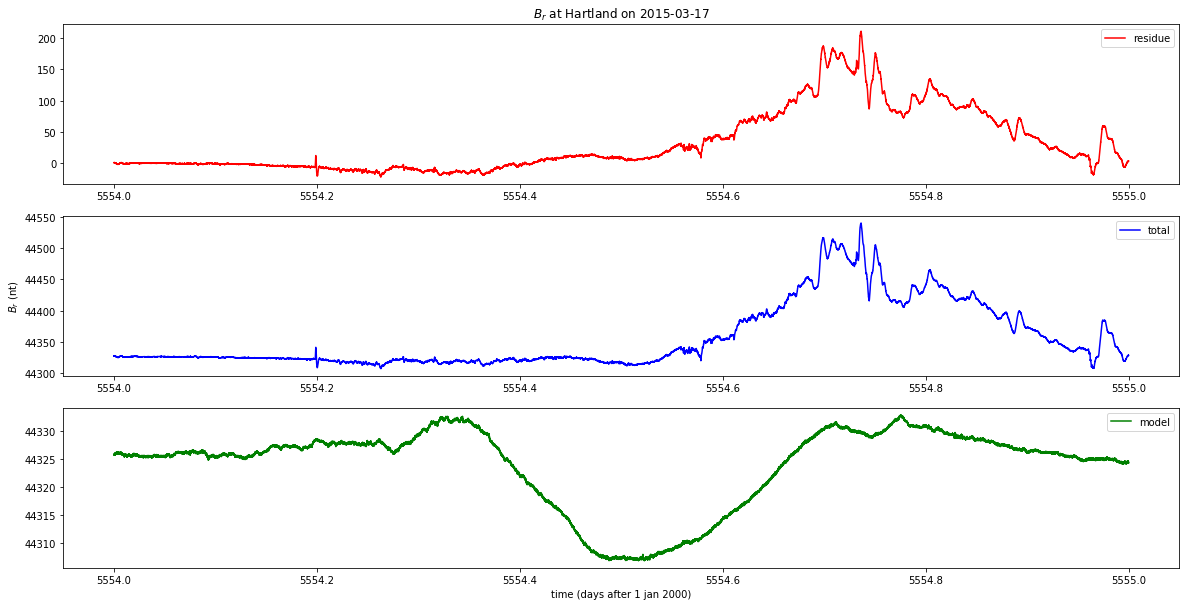

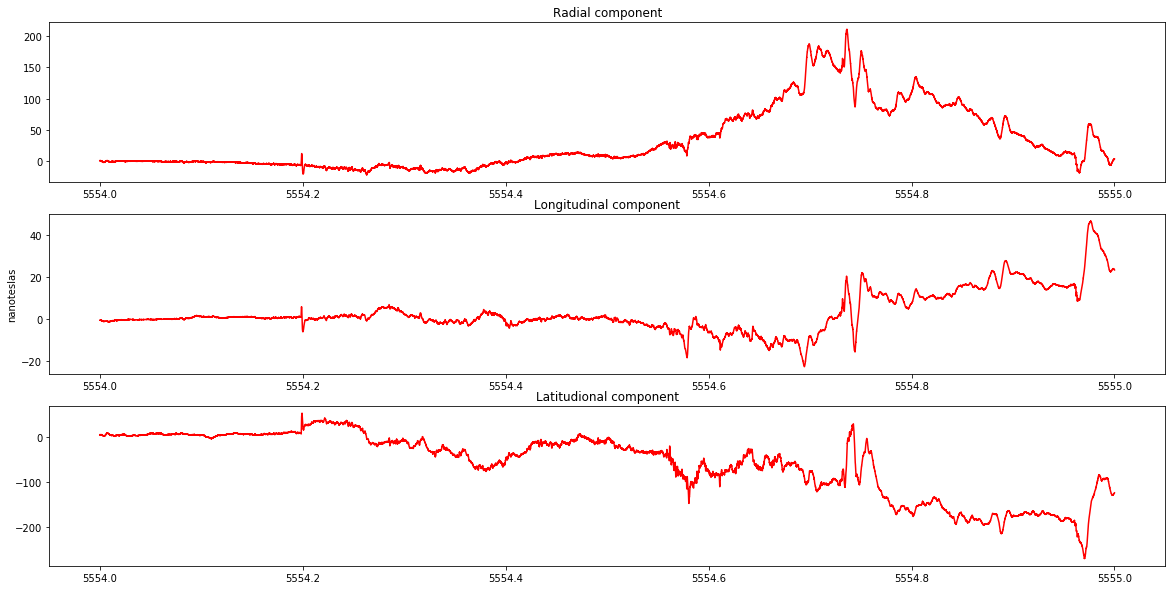

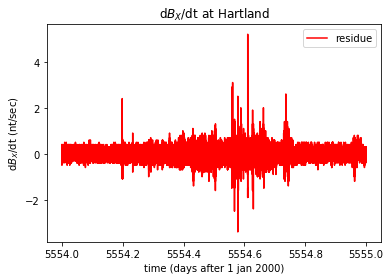

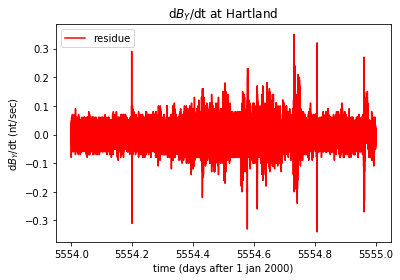

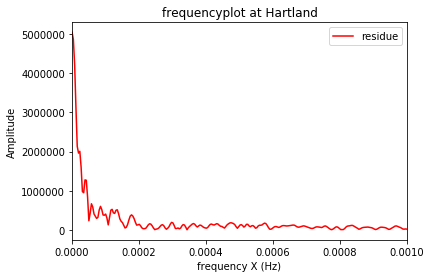

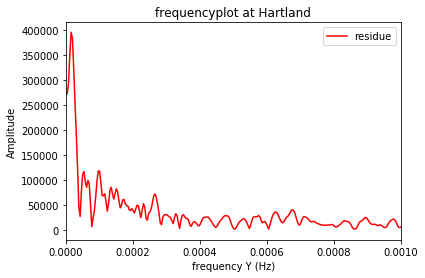

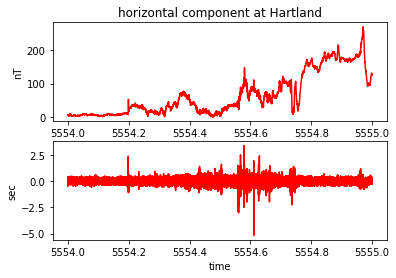

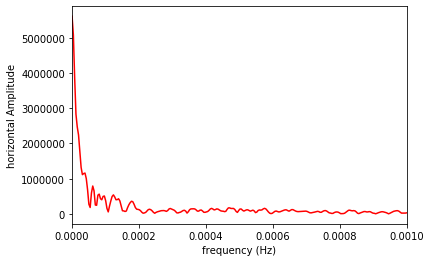

In [35]:
newplotspace('magnetic_data/17-3-2015(sec)/had20150317psec.sec','magnetic_data/17-3-2015(sec)/had20150310psec.sec',22,False,True)

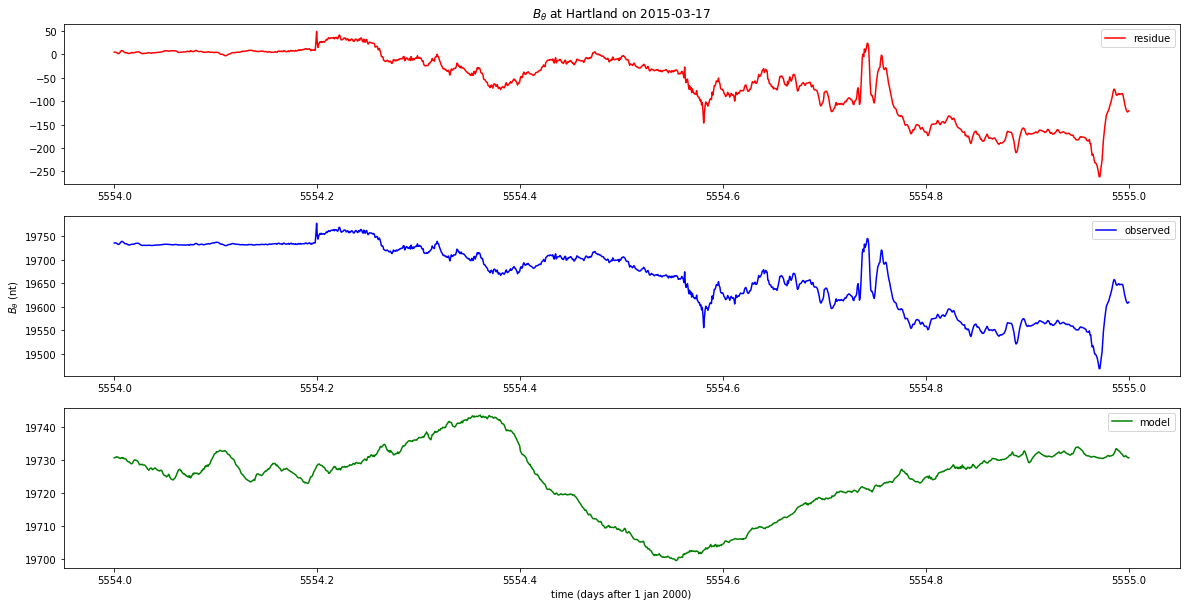

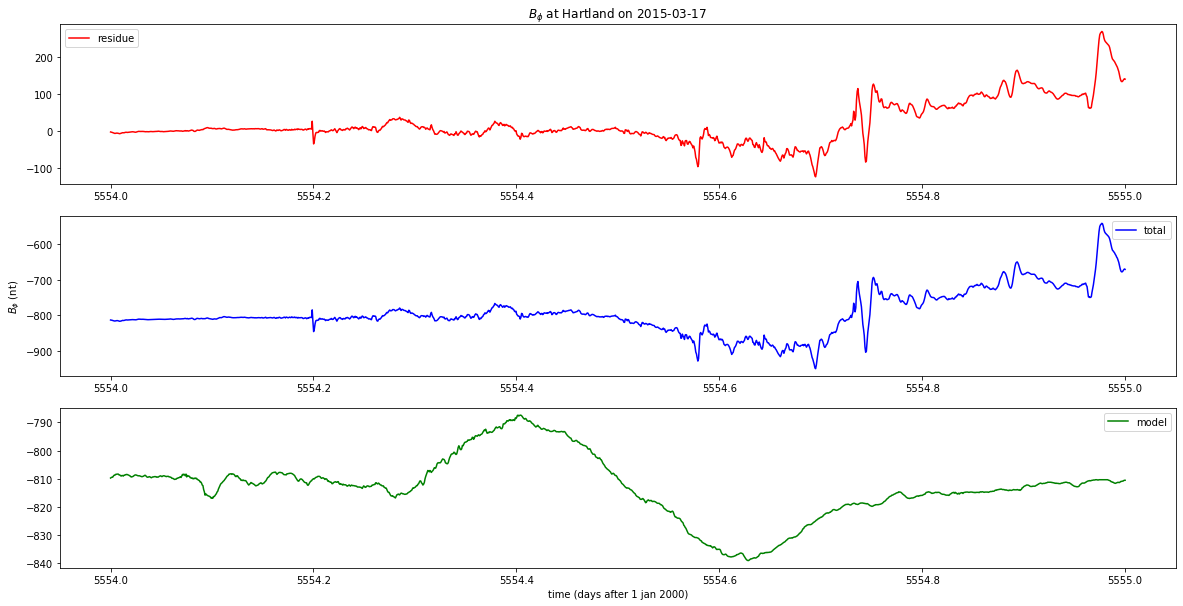

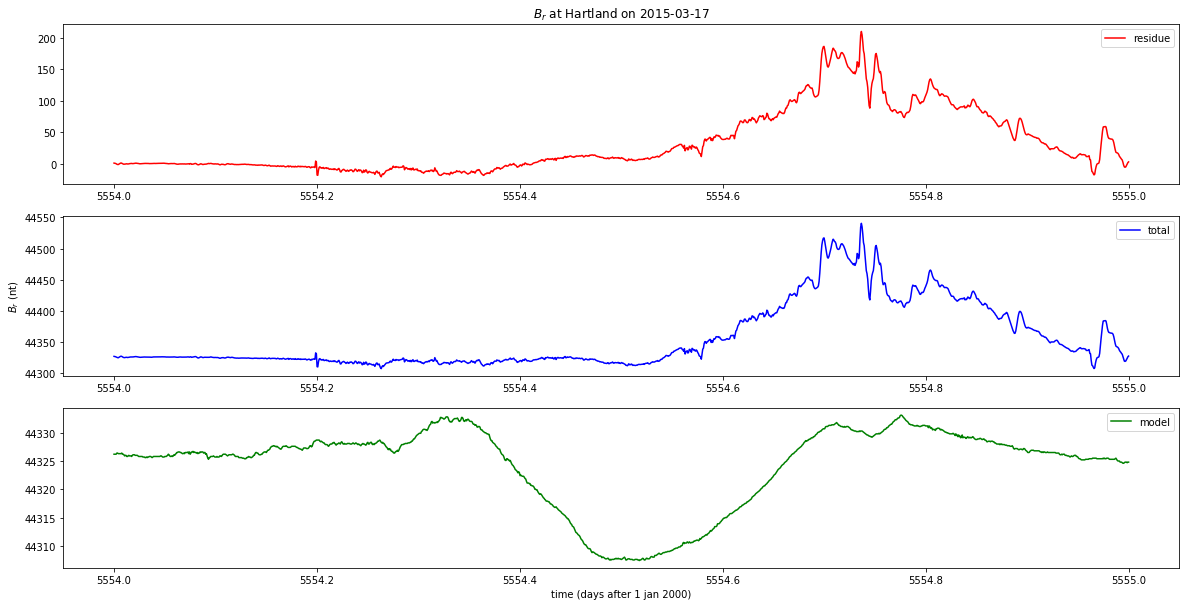

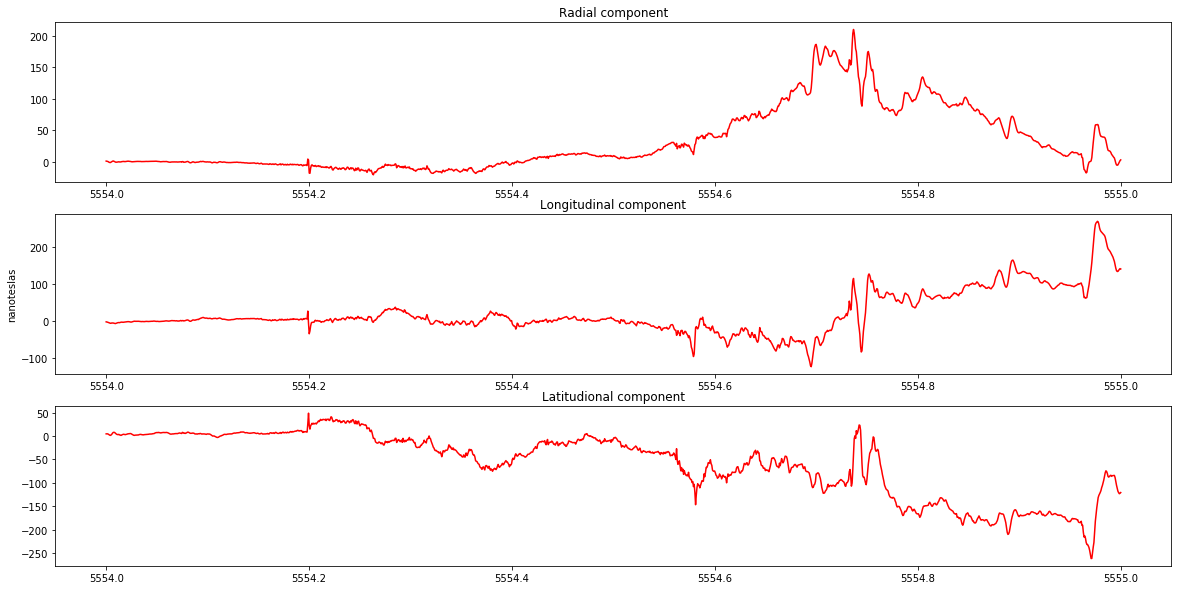

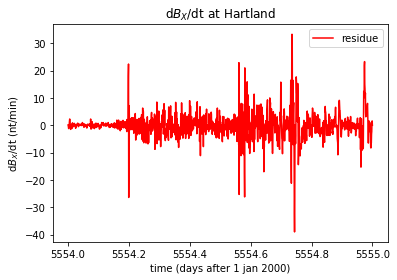

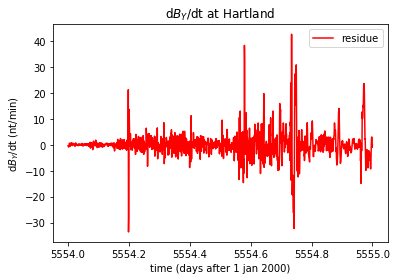

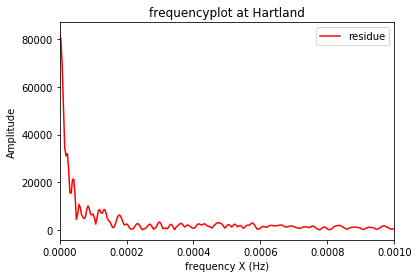

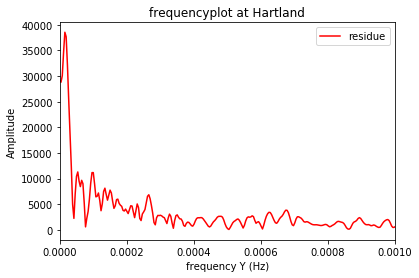

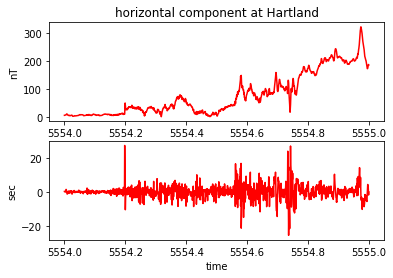

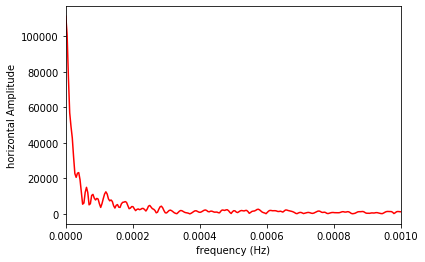

In [34]:
newplotspace('magnetic_data/17-3-2015(min)/had20150317dmin.min','magnetic_data/17-3-2015(min)/had20150310dmin.min',26,True,False)